# LangGraph and LangSmith - Agentic RAG Powered by LangChain

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!

  - 🤝 Breakout Room #2:
  1. Evaluating the LangGraph Application with LangSmith
  2. Adding Helpfulness Check and "Loop" Limits
  3. LangGraph for the "Patterns" of GenAI

# 🤝 Breakout Room #1

## Part 1: LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

### Why LangGraph?

Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

## Task 1:  Dependencies

We'll first install all our required libraries.

In [2]:
%pip install -qU langchain langchain_openai langchain-community langgraph arxiv duckduckgo_search==5.3.1b1

Note: you may need to restart the kernel to use updated packages.


## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [4]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE4 - LangGraph - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Duck Duck Go Web Search](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/ddg_search)
- [Arxiv](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/arxiv)

####🏗️ Activity #1:

Please add the tools to use into our toolbelt.

> NOTE: Each tool in our toolbelt should be a method.

In [8]:
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
from langchain_community.tools.arxiv.tool import ArxivQueryRun

tool_belt = [
    DuckDuckGoSearchRun(), ArxivQueryRun()
]

#added the required tools in a list, parenthesis due to tools being methods

### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - but it's not *necessary* to use with LangGraph. LangGraph supports all models - though you might not find success with smaller models - as such, they recommend you stick with:

- OpenAI's GPT-3.5 and GPT-4
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [9]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [10]:
model = model.bind_tools(tool_belt)

#### ❓ Question #1:

How does the model determine which tool to use?

In [ ]:
#the agent looks at the query and uses the context to determine which tool to use
    #similarity of tokens to input
#if it says "search for" then the agent would know to use the go duck go search tool
#if it says "show me a paper on" then agent knows to use arXiv, since it is a public repo of archives (research and scholarly comms)

## Task 4: Putting the State in Stateful

Earlier we used this phrasing:

`coordinated multi-actor and stateful applications`

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. We initialize our state object:
  - `{"messages" : []}`
2. Our user submits a query to our application.
  - New State: `HumanMessage(#1)`
  - `{"messages" : [HumanMessage(#1)}`
3. We pass our state object to an Agent node which is able to read the current state. It will use the last `HumanMessage` as input. It gets some kind of output which it will add to the state.
  - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
  - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass our state object to a "conditional node" (more on this later) which reads the last state to determine if we need to use a tool - which it can determine properly because of our provided object!

In [11]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

## Task 5: It's Graphing Time!

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".

Let's create some nodes and expand on our diagram.

> NOTE: Due to the tight integration with LCEL - we can comfortably create our nodes in an async fashion!

In [12]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

tool_node = ToolNode(tool_belt)

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `tool_node` is a node which can call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [13]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

Let's look at what we have so far:

![image](https://i.imgur.com/md7inqG.png)

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [14]:
uncompiled_graph.set_entry_point("agent")

![image](https://i.imgur.com/wNixpJe.png)

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [15]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

Let's visualize what this looks like.

![image](https://i.imgur.com/8ZNwKI5.png)

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [16]:
uncompiled_graph.add_edge("action", "agent")

Let's look at the final visualization.

![image](https://i.imgur.com/NWO7usO.png)

All that's left to do now is to compile our workflow - and we're off!

In [17]:
compiled_graph = uncompiled_graph.compile()

#### ❓ Question #2:

Is there any specific limit to how many times we can cycle?

If not, how could we impose a limit to the number of cycles?

In [ ]:
# There is not a specific limit to the number of times we can cycle

#put should-continue in a loop, and force a break after a certain number of iterations
#or add a recursion limit feature 

## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:

In [18]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="Who is the current captain of the Winnipeg Jets?")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bSLeQVGRjUqZSvk0wTHmjrYO', 'function': {'arguments': '{"query":"current captain of the Winnipeg Jets 2023"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 156, 'total_tokens': 181}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-55af4279-e07e-4d05-a638-27916bf8914e-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'current captain of the Winnipeg Jets 2023'}, 'id': 'call_bSLeQVGRjUqZSvk0wTHmjrYO', 'type': 'tool_call'}], usage_metadata={'input_tokens': 156, 'output_tokens': 25, 'total_tokens': 181})]



Receiving update from node: 'action'
[ToolMessage(content='Posted September 12, 2023 9:29 am. Centre Adam Lowry was named the Winnipeg Jets new captain on Tuesday. Lowry is the third Je

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "tool_calls" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "tool_calls" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [19]:
inputs = {"messages" : [HumanMessage(content="Search Arxiv for the QLoRA paper, then search each of the authors to find out their latest Tweet using DuckDuckGo.")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])

        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KJVyEg3RbzW7o00qS0NUG9mg', 'function': {'arguments': '{"query": "QLoRA"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_yyg1bpttLyj2bMthyN2HH2TD', 'function': {'arguments': '{"query": "latest Tweet"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 173, 'total_tokens': 223}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-474157a9-99c6-4bba-863f-bcfc5634d688-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'QLoRA'}, 'id': 'call_KJVyEg3RbzW7o00qS0NUG9mg', 'type': 'tool_call'}, {'name': 'duckduckgo_search', 'args': {'query': 'latest Tweet'}, 'id': 'call_yyg1bpttLyj2bMthyN2HH2TD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 173, 'output_tokens': 50, 'total_tokens': 223})]



Receivin

####🏗️ Activity #2:

Please write out the steps the agent took to arrive at the correct answer.

In [ ]:
#entrypoint is at agent
#input specifies for agent to use arXiv to find paper
    #agent doesn't have an answer for the first query, goes to action to retrieve requested tool and get answer
        #agent uses arXiv from the toolbelt to search for the paper, returns values
#input specifies for agent to search for tweet using DuckDuckGo
    #agent doesn't have the answer from DuckDuckGo, goes to action to retrieve requested tool to get answer
        #agent uses DuckDuckGo search tool to find tweets
#agent has fully answered the query
#should_continue returns 'end'

## Part 1: LangSmith Evaluator

### Pre-processing for LangSmith

To do a little bit more preprocessing, let's wrap our LangGraph agent in a simple chain.

In [20]:
def convert_inputs(input_object):
  return {"messages" : [HumanMessage(content=input_object["question"])]}

def parse_output(input_state):
  return input_state["messages"][-1].content

agent_chain = convert_inputs | compiled_graph | parse_output

In [21]:
agent_chain.invoke({"question" : "What is RAG?"})

'RAG stands for Retrieval-Augmented Generation. It is a technique used in natural language processing (NLP) and machine learning to improve the performance of language models by combining retrieval-based methods with generative models. Here’s a brief overview of how it works:\n\n1. **Retrieval**: In the first step, the system retrieves relevant documents or pieces of information from a large corpus or database. This is typically done using a retrieval model, such as BM25 or a dense retrieval model like DPR (Dense Passage Retrieval).\n\n2. **Augmentation**: The retrieved documents are then used to augment the input to the generative model. This means that the generative model has access to additional context or information that can help it produce more accurate and relevant responses.\n\n3. **Generation**: Finally, the generative model (such as GPT-3 or BERT) uses the augmented input to generate a response. The additional context provided by the retrieved documents helps the model gener

### Task 1: Creating An Evaluation Dataset

Just as we saw last week, we'll want to create a dataset to test our Agent's ability to answer questions.

In order to do this - we'll want to provide some questions and some answers. Let's look at how we can create such a dataset below.

```python
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]
```

####🏗️ Activity #3:

Please create a dataset in the above format with at least 5 questions.

In [22]:
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]

Now we can add our dataset to our LangSmith project using the following code which we saw last Thursday!

In [23]:
from langsmith import Client

client = Client()
dataset_name = f"Retrieval Augmented Generation - Evaluation Dataset - {uuid4().hex[0:8]}"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the QLoRA Paper to Evaluate RAG over the same paper."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    outputs=answers,
    dataset_id=dataset.id,
)

#### ❓ Question #3:

How are the correct answers associated with the questions?

> NOTE: Feel free to indicate if this is problematic or not

In [ ]:
#the correct answers are associated by if they use the key words provided.

#this could be problematic if the keywords are spelled differently (different case or typos)


### Task 2: Adding Evaluators

Now we can add a custom evaluator to see if our responses contain the expected information.

We'll be using a fairly naive exact-match process to determine if our response contains specific strings.

In [24]:
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    return EvaluationResult(key="must_mention", score=score)

#### ❓ Question #4:

What are some ways you could improve this metric as-is?

> NOTE: Alternatively you can suggest where gaps exist in this method.

In [ ]:
#instead of forcing certain words to be used in the answer, we could go back to using cosine similarity to make it topically similar

Now that we have created our custom evaluator - let's initialize our `RunEvalConfig` with it!

In [25]:
from langchain.smith import RunEvalConfig, run_on_dataset

eval_config = RunEvalConfig(
    custom_evaluators=[must_mention],
)

Task 3: Evaluating

All that is left to do is evaluate our agent's response!

In [26]:
client.run_on_dataset(
    dataset_name=dataset_name,
    llm_or_chain_factory=agent_chain,
    evaluation=eval_config,
    verbose=True,
    project_name=f"RAG Pipeline - Evaluation - {uuid4().hex[0:8]}",
    project_metadata={"version": "1.0.0"},
)

View the evaluation results for project 'RAG Pipeline - Evaluation - a281615e' at:
https://smith.langchain.com/o/2f518fba-2c1b-5c4b-96c1-22f9cb267b88/datasets/0cf278cd-8627-4817-a6c0-b44a0d14ca73/compare?selectedSessions=ecfc1a92-7bf3-4fcc-a8d8-4709ad15e86d

View all tests for Dataset Retrieval Augmented Generation - Evaluation Dataset - c2be1b9f at:
https://smith.langchain.com/o/2f518fba-2c1b-5c4b-96c1-22f9cb267b88/datasets/0cf278cd-8627-4817-a6c0-b44a0d14ca73
[------------------------------------------------->] 6/6

,feedback.must_mention,error,execution_time,run_id
count,6,0,6.000000,6
unique,2,0,NaN,6
top,True,NaN,NaN,2cd6f6c2-e1b7-4324-80e3-7797203a7057
freq,3,NaN,NaN,1
mean,NaN,NaN,10.209136,NaN
std,NaN,NaN,1.035650,NaN
min,NaN,NaN,8.597380,NaN
25%,NaN,NaN,9.821621,NaN
50%,NaN,NaN,10.221058,NaN
75%,NaN,NaN,10.711367,NaN


{'project_name': 'RAG Pipeline - Evaluation - a281615e',
 'results': {'e8d5740e-90aa-4217-942b-1e0c6cb14b6a': {'input': {'question': 'What optimizer is used in QLoRA?'},
   'feedback': [EvaluationResult(key='must_mention', score=True, value=None, comment=None, correction=None, evaluator_info={}, feedback_config=None, source_run_id=UUID('8eab8b18-ff33-4b3f-b4af-1c7e3109ab64'), target_run_id=None)],
   'execution_time': 10.859651,
   'run_id': '2cd6f6c2-e1b7-4324-80e3-7797203a7057',
   'output': 'QLoRA (Quantized Low-Rank Adaptation) uses a combination of optimizers to manage memory efficiently during the fine-tuning of large language models. Specifically, it introduces "paged optimizers" to handle memory spikes. This approach allows QLoRA to backpropagate gradients through a frozen, 4-bit quantized pretrained language model into Low Rank Adapters (LoRA), significantly reducing memory usage without sacrificing performance.',
   'reference': {'must_mention': ['paged', 'optimizer']}},
  '1

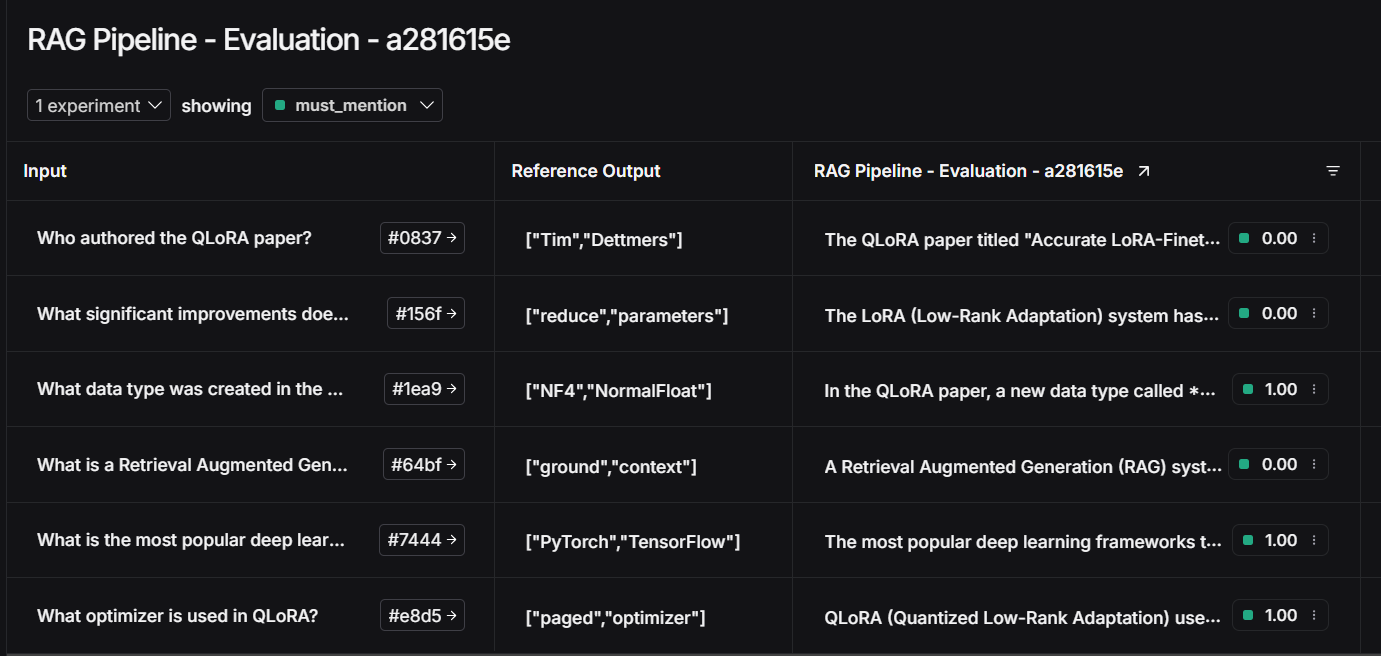

the 1(T) or 0(F) shows if the terms were included
most of the evaluations were 0, so it didn't do a great job of meeting the evaluation criteria


## Part 2: LangGraph with Helpfulness:

### Task 3: Adding Helpfulness Check and "Loop" Limits

Now that we've done evaluation - let's see if we can add an extra step where we review the content we've generated to confirm if it fully answers the user's query!

We're going to make a few key adjustments to account for this:

1. We're going to add an artificial limit on how many "loops" the agent can go through - this will help us to avoid the potential situation where we never exit the loop.
2. We'll add to our existing conditional edge to obtain the behaviour we desire.

First, let's define our state again - we can check the length of the state object, so we don't need additional state for this.

In [27]:
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

Now we can set our graph up! This process will be almost entirely the same - with the inclusion of one additional node/conditional edge!

####🏗️ Activity #5:

Please write markdown for the following cells to explain what each is doing.

##### YOUR MARKDOWN HERE
the following cell creates the nodes for the workflow, the agent node is were the model is called, while the action node is the tool node where it decides which tool to use based on the input

In [28]:
graph_with_helpfulness_check = StateGraph(AgentState)

graph_with_helpfulness_check.add_node("agent", call_model)
graph_with_helpfulness_check.add_node("action", tool_node)

##### YOUR MARKDOWN HERE
This cell sets the entry point at the agent node

In [29]:
graph_with_helpfulness_check.set_entry_point("agent")

##### YOUR MARKDOWN HERE
This cell sets the flow for the agent. It sets the iteration limit, loads the prompt, shows which model to use, etc. further notes in the code block.

In [30]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
#imports lanchain methods to be used

def tool_call_or_helpful(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  initial_query = state["messages"][0]
  final_response = state["messages"][-1]

  if len(state["messages"]) > 10:
    return "END"
  #forces cycle to end after 10 iterations

  prompt_template = """\
  Given an initial query and a final response, determine if the final response is extremely helpful or not. Please indicate helpfulness with a 'Y' and unhelpfulness as an 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""
  #evaluates if the final response is helpful based on the initial query and final response variables

  prompt_template = PromptTemplate.from_template(prompt_template)
  #uses langchain method to generate prompt template, args for prompt template are above

  helpfulness_check_model = ChatOpenAI(model="gpt-4")
  #shows which model to use

  helpfulness_chain = prompt_template | helpfulness_check_model | StrOutputParser()
  #converts llm output to string

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})
  #uses helpfulness chain to determine if helpful

  if "Y" in helpfulness_response:
    return "end"
  else:
    return "continue"
  #if helpful, sequence ends. if not, sequence continues back to agent

####🏗️ Activity #4:

Please write what is happening in our `tool_call_or_helpful` function!

##### YOUR MARKDOWN HERE

sets the states that show when the cycle continues or ends

In [31]:
graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    tool_call_or_helpful,
    {
        "continue" : "agent",
        "action" : "action",
        "end" : END
    }
)
#when agent is returned, the cycle continues
#action shows the action being used
#cycle ends when end is returned based on 10 cycle iteration or helpful response

##### YOUR MARKDOWN HERE

add edge to allow for continuous cycling

In [32]:
graph_with_helpfulness_check.add_edge("action", "agent")

#adds edge between action and agent to enable cycling through the agent multiple times

##### YOUR MARKDOWN HERE

compilation of the helpfulness check

In [33]:
agent_with_helpfulness_check = graph_with_helpfulness_check.compile()

#agent will use the helpfulness check to determine if the cycle will continue

##### YOUR MARKDOWN HERE

provides the input and prints the node locations and content at each node

In [34]:
inputs = {"messages" : [HumanMessage(content="Related to machine learning, what is LoRA? Also, who is Tim Dettmers? Also, what is Attention?")]}

async for chunk in agent_with_helpfulness_check.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

#will continue to cycle through until the response is deemed helpful

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UZIgM9JTWkM6EkZ60BpVMkjU', 'function': {'arguments': '{"query": "LoRA machine learning"}', 'name': 'duckduckgo_search'}, 'type': 'function'}, {'id': 'call_wvnFtMzJGuzV2WSjRQOHgkwe', 'function': {'arguments': '{"query": "Tim Dettmers"}', 'name': 'duckduckgo_search'}, 'type': 'function'}, {'id': 'call_RlvMGOu88iTMMTQj8o0fs3qW', 'function': {'arguments': '{"query": "Attention in machine learning"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 171, 'total_tokens': 247}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-43b9294e-e5b3-4bc2-85c0-bf4ae4594d9d-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'LoRA machine learning'}, 'id': 'call_UZIgM9JTWkM6EkZ60BpVMkjU', 'type': 'tool_call'}, 

### Task 4: LangGraph for the "Patterns" of GenAI

Let's ask our system about the 4 patterns of Generative AI:

1. Prompt Engineering
2. RAG
3. Fine-tuning
4. Agents

In [35]:
patterns = ["prompt engineering", "RAG", "fine-tuning", "LLM-based agents"]

#each element of the list will be passed into the what_is_string variable

In [36]:
for pattern in patterns:
  what_is_string = f"What is {pattern} and when did it break onto the scene??"
  inputs = {"messages" : [HumanMessage(content=what_is_string)]}
  messages = agent_with_helpfulness_check.invoke(inputs)
  print(messages["messages"][-1].content)
  print("\n\n")

Prompt engineering is a concept primarily associated with the field of artificial intelligence, particularly in the context of natural language processing (NLP) and large language models (LLMs) like GPT-3. It involves the design and crafting of prompts (input text) to elicit desired responses from AI models. The goal is to optimize the input to get the most accurate, relevant, or useful output from the model.

### Key Aspects of Prompt Engineering:
1. **Crafting Effective Prompts**: Designing prompts that are clear, specific, and structured in a way that guides the AI to produce the desired output.
2. **Iterative Testing**: Continuously refining prompts based on the responses received to improve the quality and relevance of the output.
3. **Understanding Model Behavior**: Gaining insights into how the model interprets different types of prompts and using this understanding to influence the responses.

### Emergence of Prompt Engineering:
Prompt engineering became more prominent with th